In [1]:
import sys
import pandas as pd
import warnings
import seaborn as sns
from typing import List, Union
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pca import pca as pca_func
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.colors as mcolors

sys.path.append('functions')
from data_frame_handler import DataFrameHandler as dfh

# main path to file with data. Can be easily changed
file_path = 'data/urine_test_data.csv'

Step 0: Data prep

In [2]:
df = dfh.read_csv_data(file_path)

# Use a list comprehension to dynamically select matching columns
organisms = dfh.select_columns_by_search_terms(df, ['organism'])
genes = dfh.select_columns_by_search_terms(df, ['gene'])
antibiotics = dfh.select_columns_by_search_terms(df, ['antibiotic'])

# Set the 'Type' column to the values in gene_data_str - FUTURE Labels
gene_data_str = df[genes].applymap(str).agg(''.join, axis=1)
df['Type'] = gene_data_str

In [3]:
# Get a colormap based on the number of unique 'Type' values
geneset_unique_types = df['Type'].unique()
num_unique_types = len(geneset_unique_types)
cmap = plt.get_cmap('tab20', num_unique_types)

# Create a mapping of 'Type' values to colors
type_colors = {type_value: cmap(i) for i, type_value in enumerate(geneset_unique_types)}

# Map 'Type' values to colors in a new Series
type_colors_series = df['Type'].map(type_colors)

Step 1: PCA data preparation

In [4]:
# Transform data to binary present/absent format
X = df[organisms].applymap(lambda x: 1 if x > 0 else 0)

# If you choose not to scale, then use X directly in PCA
# not really X_scaled, but it makes the following code reusable
X_scaled = X  # Change this to X_scaled if you decide to scale

Step 2: Perform PCA

In [5]:
# Initialize PCA with the number of components you want to retain
# In this example, let's retain all components for now
pca_model = PCA()

# Fit PCA to the data
pca_model.fit(X_scaled)

PCA()

Step 3: Plot (scree) explained variance. In the cumulative explained variance plot, you'll see the cumulative proportion of total variance explained by each component.

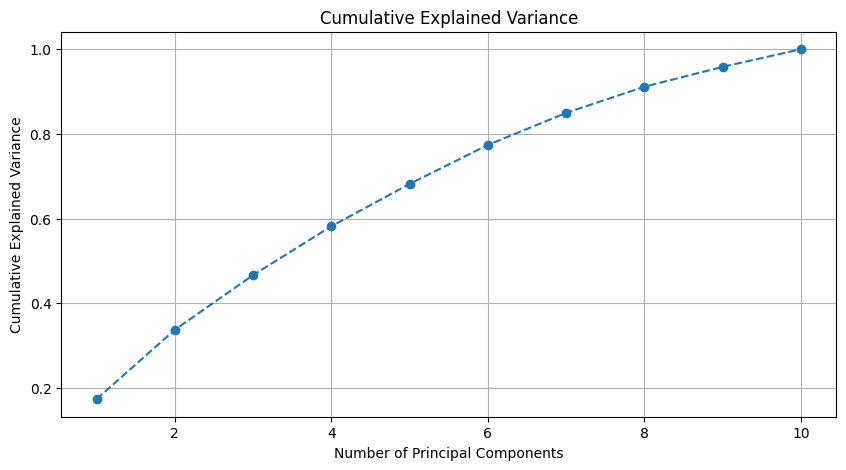

In [6]:
# Plot explained variance
explained_variance = pca_model.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Step 4: Interpretation.
A common rule of thumb is to retain enough components to explain a substantial portion of the total variance, often 95% or more. In this plot, we can see there isn't really a point where the cumulative explained variance levels off. This indicates that PCA may not be waranted here, as there isn't a reflection point of diminishing returns in terms of explaining additional variance.

Choose number of components. Based on the chart above, we may be tempted to use all possible components. However, this will result in an over-parameterized function and likely not provide any meaningful insight to the data nor useful functions for further predictions. However, for the 'fun' of this exercise, let's go with 8 components to get past at least some quantifiable sigma level.

In [7]:
# Choose the number of components to retain (e.g., n)
n = 8
print(f"Components (n): {n}")

Components (n): 8


In [8]:
# Create a new PCA instance with the chosen number of components
pca_model = PCA(n_components=n)

# Fit and transform the data
X_pca = pca_model.fit_transform(X_scaled)

Step 5: Interpret Principal Components.
Interpret the principal components to understand the directions in which the original variables contribute the most to the variance. 
You can inspect the loadings of each principal component to understand which variables have the highest weights.

In [9]:
# Get the loadings for all principal components
loadings_all_components = pca_model.components_

# Create a DataFrame with variable loadings for all components
loadings_df = pd.DataFrame(loadings_all_components, columns=organisms)

# Calculate the explained variance for each component
explained_variance = pca_model.explained_variance_ratio_
loadings_df['Explained Variance'] = explained_variance

# Display the DataFrame
# print("Variable Loadings and Explained Variance for All Principal Components:")
# print(loadings_df)

Here are the Principal Components and the amount each Organism contributes to the model & PC.

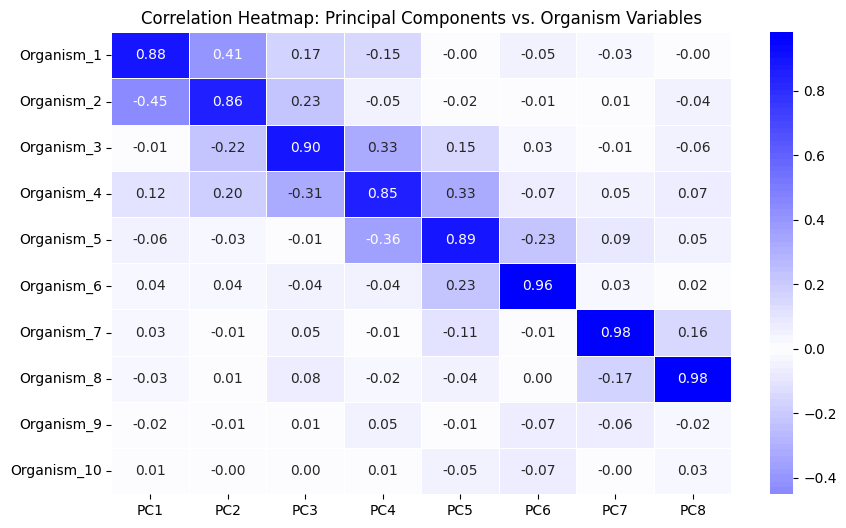

In [10]:
# Create a custom colormap that transitions from red (for high negative values) to white (for zero) to red (for high positive values)
colors = ["blue", "white", "blue"]
cmap_name = "custom_div_cmap"
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

component_variable_correlation = pd.DataFrame(pca_model.components_.T, columns=[f'PC{i}' for i in range(1, n+1)], index=organisms)
plt.figure(figsize=(10, 6))

sns.heatmap(component_variable_correlation, cmap=cm, annot=True, fmt=".2f", linewidths=0.5, center=0)

plt.title('Correlation Heatmap: Principal Components vs. Organism Variables')
plt.show()

The amount of variance each PC explains.

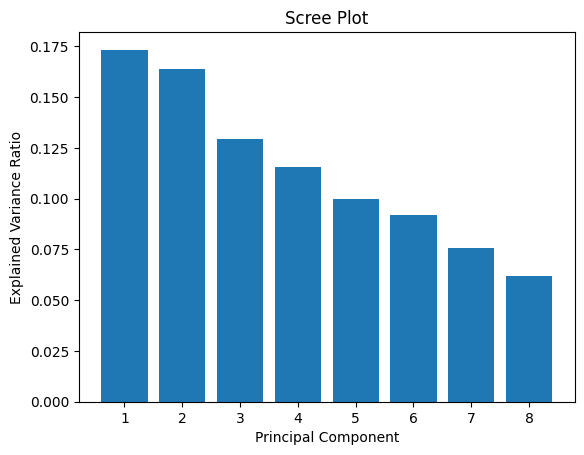

In [11]:
explained_variance = pca_model.explained_variance_ratio_
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

Let's compare Principal Components to see if we observe any patterns or clustering

Adding in coloring for genetic typing. Creating a matrix to compare all PCs at one glance. Would probably be better to add a plotly-like setup for expanding any given subplot larger.

[scatterd] >INFO> Create scatterplot


[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca]> [WARNING]: De parameter <label> is deprecated and will not be supported in future version.
[pca] >Plot PC1 vs PC2 with loadings.


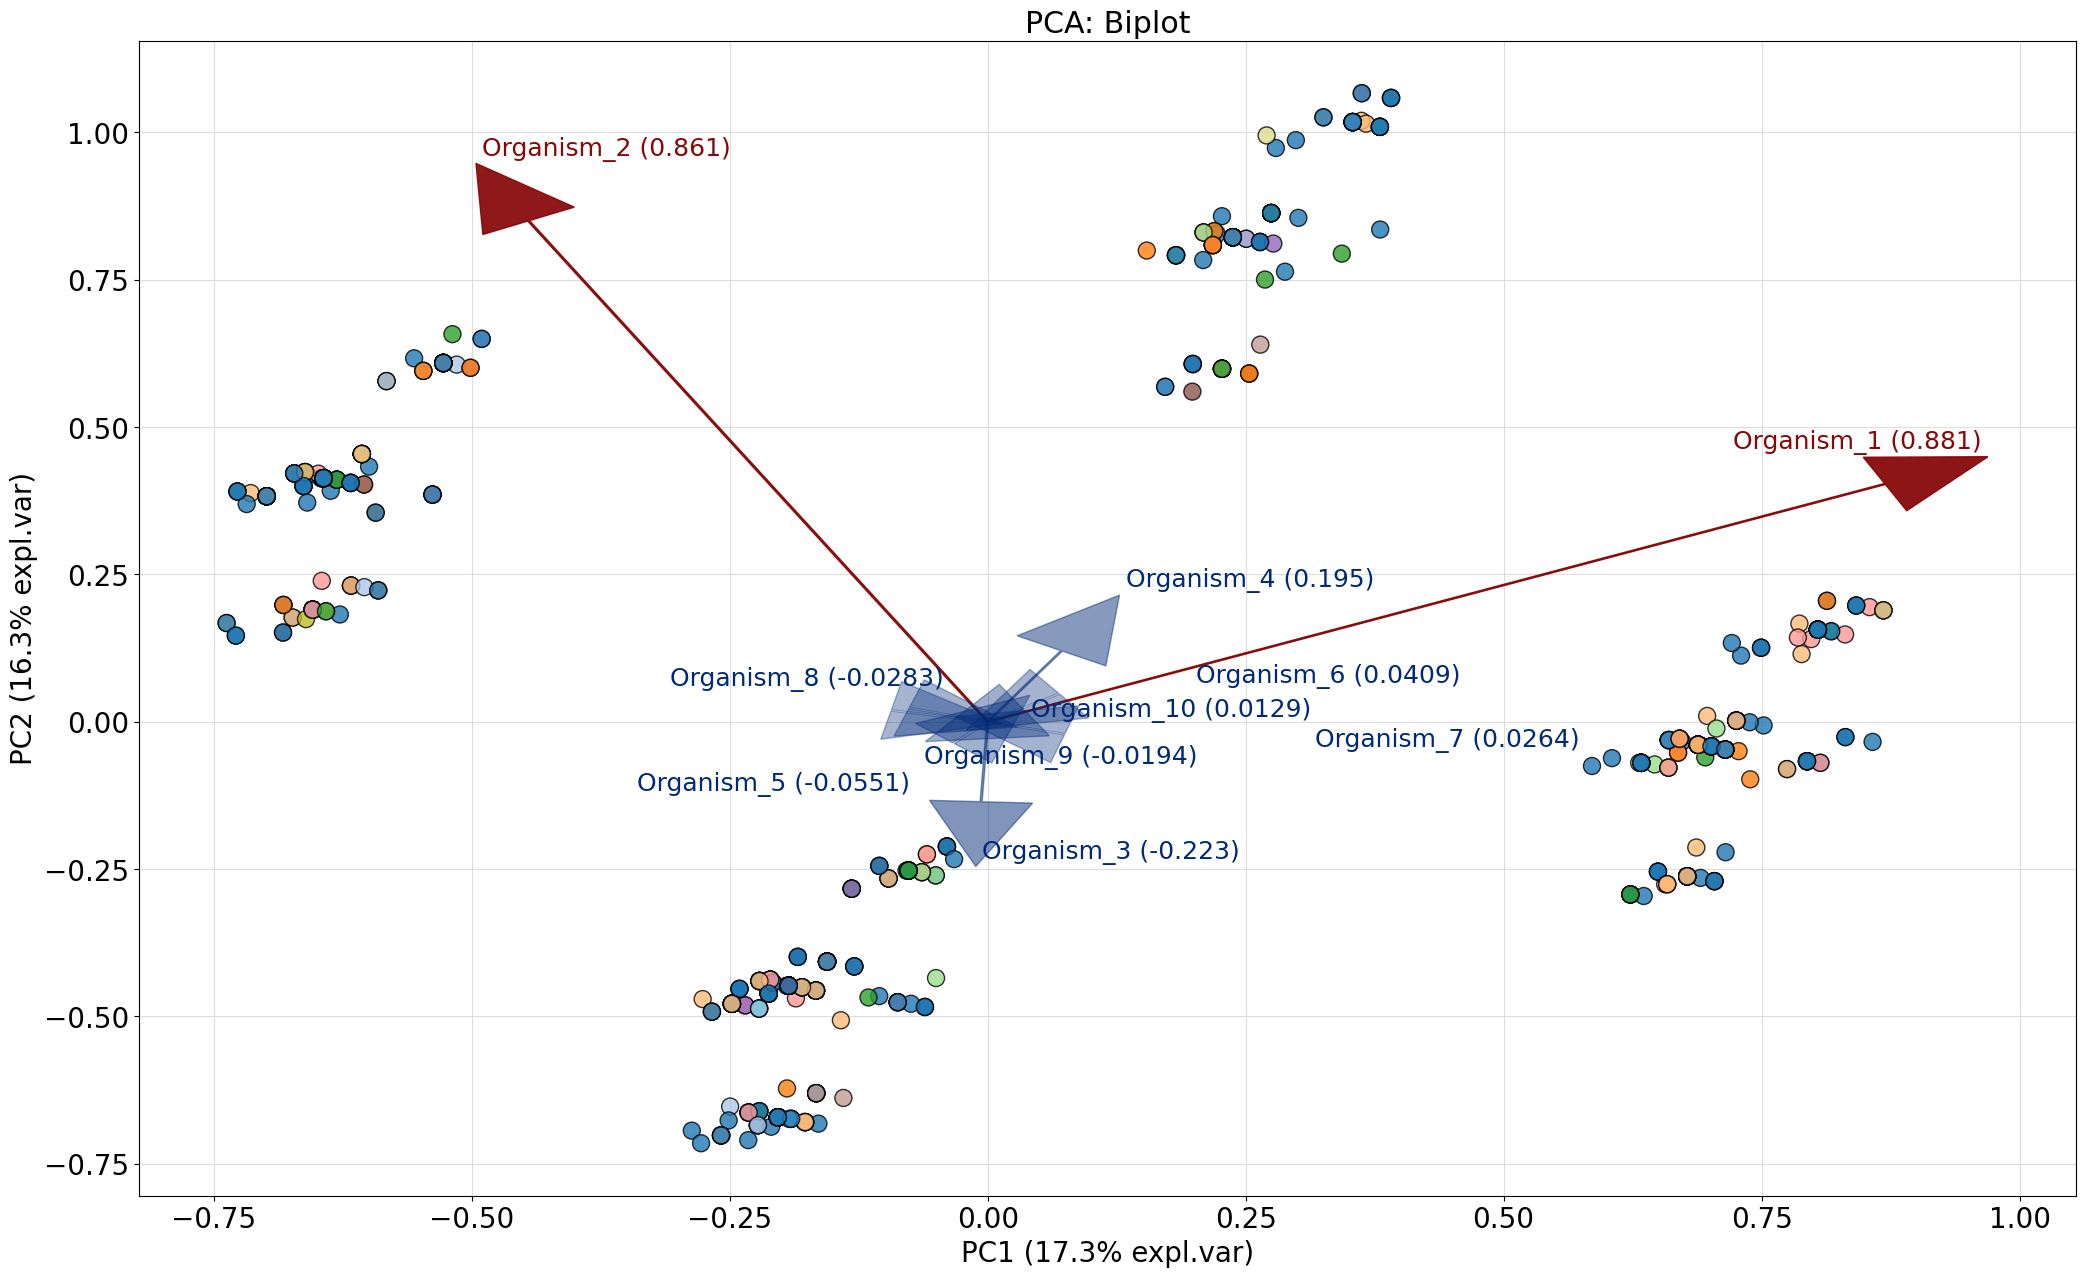

In [12]:
#Biplot: A biplot combines a scatter plot of the data points with vectors representing the loadings of variables on the principal components. 
#This allows you to see how variables and samples relate in the reduced dimensionality space.

# Fit PCA
pca_model2 = pca_func(n_components=2)
pca_results = pca_model2.fit_transform(X_scaled)

# Create biplot
pca_func.biplot(pca_model2, label=True, c=type_colors_series)
plt.title('PCA: Biplot')
plt.show()

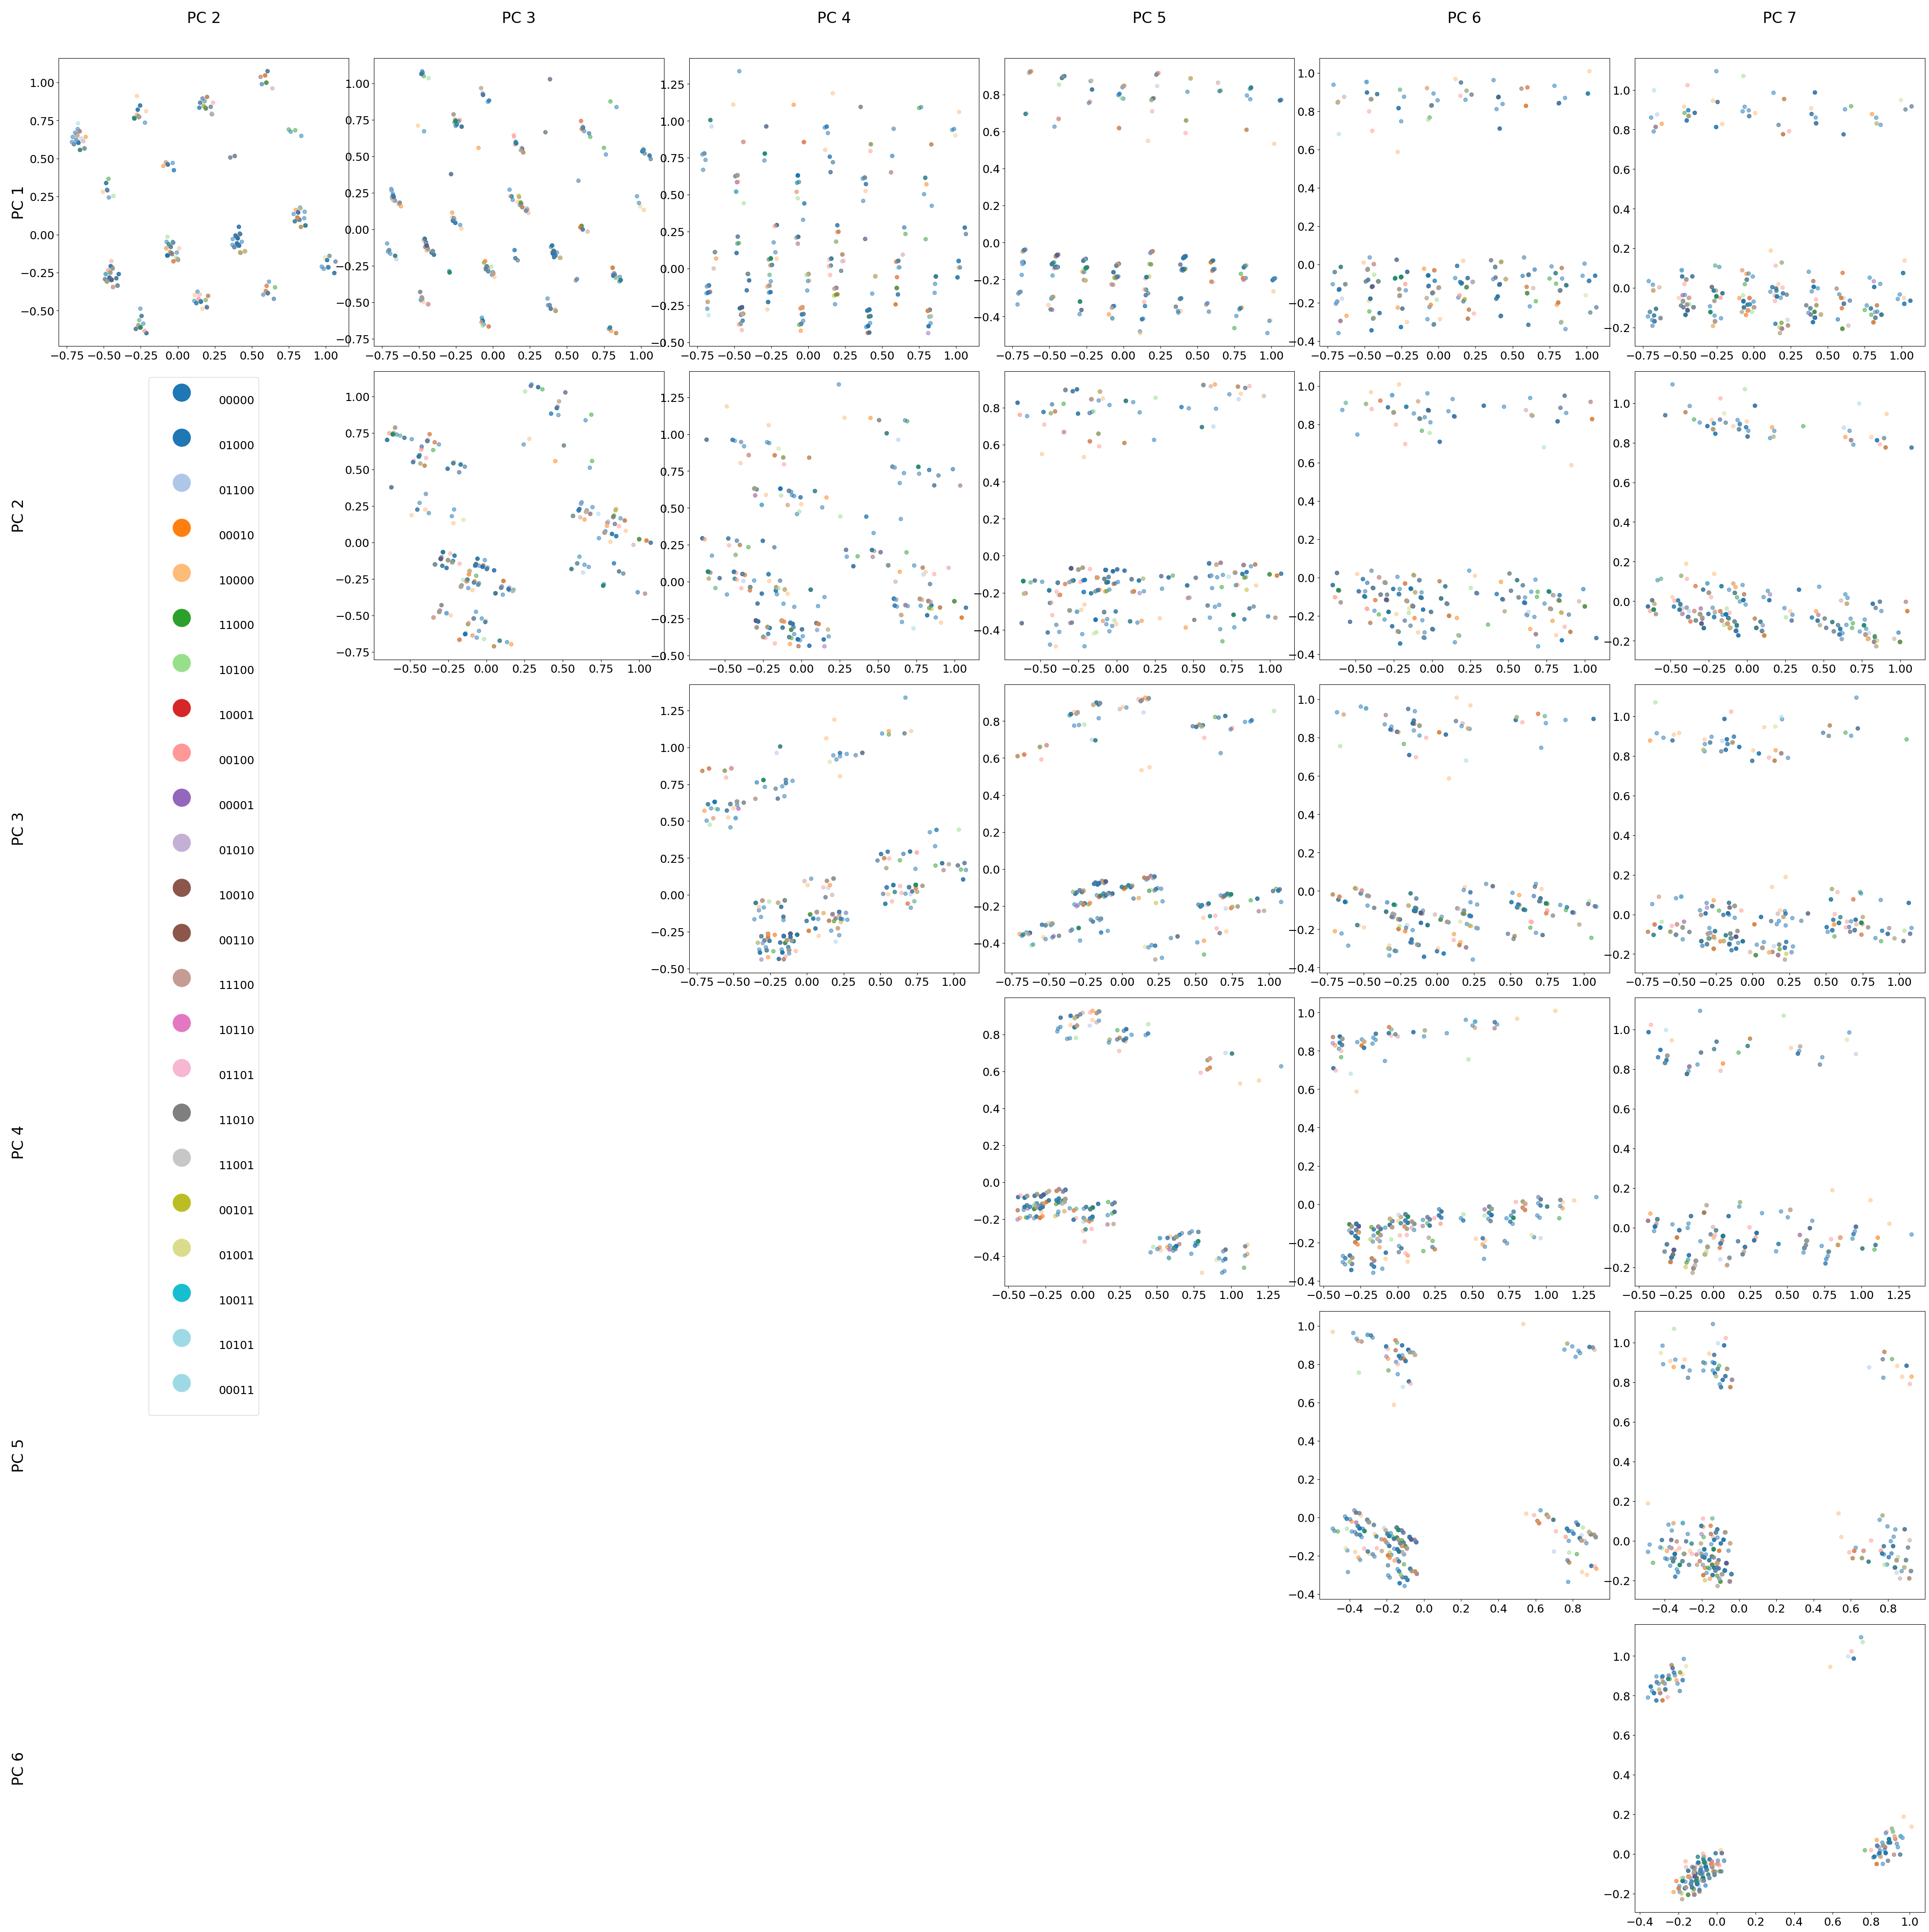

In [13]:
# Row and column labels
row_labels = [f'PC {i}' for i in range(1, n-1)]
col_labels = [f'PC {j}' for j in range(2, n)]

# Create a 6x6 subplot grid with an additional subplot column for labels
fig = plt.figure(figsize=(55, 55))
gs = gridspec.GridSpec(n-1, n-1, wspace=0.1, hspace=0.1, width_ratios=[0.1] + [1]*(n-2), height_ratios=[0.1] + [1]*(n-2))  # Adjust the width ratio for the label column

# Create subplots for data
axes = [[fig.add_subplot(gs[i+1, j+1]) for j in range(n-2)] for i in range(n-2)]

# Create subplots for row labels
row_label_ax = [fig.add_subplot(gs[i, 0]) for i in range(n-1)]
for ax in row_label_ax:
    ax.axis('off')

# Create subplots for column labels
col_label_ax = [fig.add_subplot(gs[0, j]) for j in range(n-1)]
for ax in col_label_ax:
    ax.axis('off')


# Iterate through each combination of PCs
for i in range(1, n-1):
    for j in range(2, n):
        ax = axes[i - 1][j - 2]
        if j > i:
            ax.scatter(X_pca[:, i], X_pca[:, j], c=type_colors_series, alpha=0.5)
            ax.set_xlabel('')
            ax.set_ylabel('')
        else:
            ax.axis('off')

# Set row labels
for i, label in enumerate(row_labels):
    row_label_ax[i+1].text(0.5, 0.5, label, ha='center', va='center', fontsize=24, rotation=90)

# Set column labels
for j, label in enumerate(col_labels):
    col_label_ax[j+1].text(0.5, 0.5, label, ha='center', va='center', fontsize=24)

# Create a legend for the color mapping
handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=type_colors_series[df['Type'] == type_value].iloc[0], markersize=30, label=type_value)
           for type_value in geneset_unique_types]

# Place legend - set to large size!
ax = axes[1][0]
ax.legend(handles=handles, loc='upper center', handlelength=5, handleheight=5)  # Adjust handlelength and handleheight as needed
legend = ax.get_legend()
for text in legend.get_texts():
    text.set_fontsize(18)

plt.show()

It occurs to me that looking at 1 gene at a time (P/A), for coloring might show more discernable patterns.

In [14]:
# #Variable Loadings Plot: Visualize the loadings of variables on each principal component. This can help you identify which variables contribute the most to each component.

# for i in range(0,n-1):
    
#     # Plot variable loadings for the first principal component
#     plt.bar(range(len(organisms)), pca_model.components_[i], tick_label=organisms)
#     plt.xlabel('Organism Variables')
#     plt.ylabel('Loadings')
#     plt.title(f"Variable Loadings for Principal Component {i+1}")
#     plt.xticks(rotation=90)
#     plt.show()

Vastly different conclusions here than leveraging non-transformed cell count data.
We can obviously see clustering in the plots. Though, more work is required to ident these clusters and the most informative PCs. As the case can be made that PC7 and PC8 make some great clusters.
Explained variance still does not level off very well, but does a better job than non-binary data.
Additionally, it would be trivial to now include P/A of genes into this analysis.
It is my conclusion that Linear modeling may now be appropriate avenue for model building, assuming binary transformation is leveraged.